In [1]:
# Data Generation using Modelling and Simulation for Machine Learning
# Simulation Domain: Manufacturing Queue System
# Tool: SimPy

In [2]:
!pip install simpy scikit-learn pandas numpy matplotlib
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
PARAM_BOUNDS = {
    "arrival_rate": (0.5, 2.0),
    "service_rate": (1.0, 3.0),
    "num_machines": (1, 5),
    "buffer_size": (5, 20),
    "sim_time": (200, 500)
}

In [4]:
# Simulation Function
# Output: avg_wait_time
def manufacturing_simulation(arrival_rate, service_rate, num_machines, buffer_size, sim_time):
    env = simpy.Environment()
    machines = simpy.Resource(env, capacity=int(num_machines))
    wait_times = []

    def job(env):
        arrival = env.now
        with machines.request() as req:
            yield req
            wait_times.append(env.now - arrival)
            yield env.timeout(random.expovariate(service_rate))

    def arrivals(env):
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            if len(machines.queue) < buffer_size:
                env.process(job(env))

    env.process(arrivals(env))
    env.run(until=sim_time)
    return np.mean(wait_times) if wait_times else 0


In [5]:
#Generate 1000 Sims
rows = []
for _ in range(1000):
    params = {
        k: random.uniform(v[0], v[1]) if k not in ["num_machines","buffer_size"]
        else random.randint(v[0], v[1])
        for k, v in PARAM_BOUNDS.items()
    }
    params["avg_wait_time"] = manufacturing_simulation(**params)
    rows.append(params)

df = pd.DataFrame(rows)

df.to_csv("simulation_data.csv", index=False)

In [6]:
# ML Dataset
X = df.drop("avg_wait_time", axis=1)
y = df["avg_wait_time"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [9]:
#ML Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "DecisionTree": DecisionTreeRegressor(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

results = []
for name, model in models.items():
    if name in ["SVR","KNN"]:
        model.fit(X_train_s, y_train)
        pred = model.predict(X_test_s)
    else:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

    results.append({
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_test, pred)),
        "MAE": mean_absolute_error(y_test, pred),
        "R2": r2_score(y_test, pred)
    })

results_df = pd.DataFrame(results).sort_values("RMSE")
results_df.to_csv("model_result.csv", index=False)

best_model = results_df.iloc[0]["Model"]

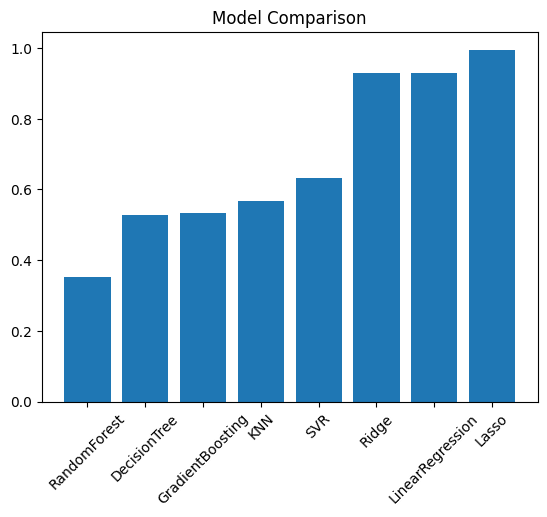

In [10]:
# Visualization
plt.figure()
plt.bar(results_df["Model"], results_df["RMSE"])
plt.xticks(rotation=45)
plt.title("Model Comparison")
plt.show()